# POD Noise Evaluation

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from rich import print

In [295]:
# load csv from disk
df0 = pd.read_csv('NOISE_EVAL_20240919-114857.csv', sep='\t')
df0.head()

,0.100,Sample#,x,dx,F,REF,Mark#
0,1.220310e+09,0.0,-39.23687,2.16735,0.40627,NaN,NaN
1,1.220310e+09,1.0,-39.19665,3.09622,0.40627,NaN,NaN
2,1.220311e+09,2.0,-39.25699,1.23849,0.42916,NaN,NaN
3,1.220311e+09,3.0,-39.23687,0.92887,0.40627,NaN,NaN
4,1.220311e+09,4.0,-39.19665,0.92887,0.41771,NaN,NaN


In [296]:
# rename first column to 'ts'
df0.rename(columns={df0.columns[0]: 'ts'}, inplace=True)
 
# and keep only 'ts', x, dx and F columns
df1 = df0[['ts', 'x', 'dx', 'F']].copy()
df1.head()


,ts,x,dx,F
0,1.220310e+09,-39.23687,2.16735,0.40627
1,1.220310e+09,-39.19665,3.09622,0.40627
2,1.220311e+09,-39.25699,1.23849,0.42916
3,1.220311e+09,-39.23687,0.92887,0.40627
4,1.220311e+09,-39.19665,0.92887,0.41771


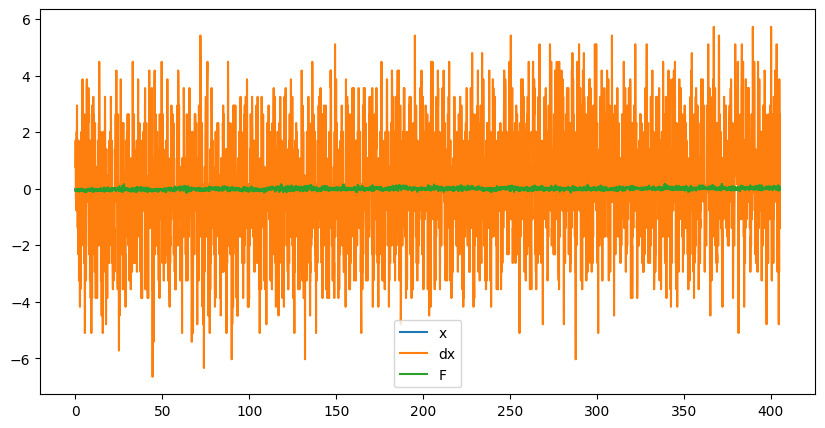

In [297]:
# make ts start from 0
df1['ts'] = df1['ts'] - df1['ts'].min()
# convert ts to seconds
df1['ts'] = df1['ts'] / 1000

# remove mean from x, dx and F
df1['x'] = df1['x'] - df1['x'].mean()
df1['dx'] = df1['dx'] - df1['dx'].mean()
df1['F'] = df1['F'] - df1['F'].mean()

# plot the data
plt.figure(figsize=(10, 5)) 
plt.plot(df1['ts'], df1['x'], label='x')
plt.plot(df1['ts'], df1['dx'], label='dx')
plt.plot(df1['ts'], df1['F'], label='F')
plt.legend()
plt.show()


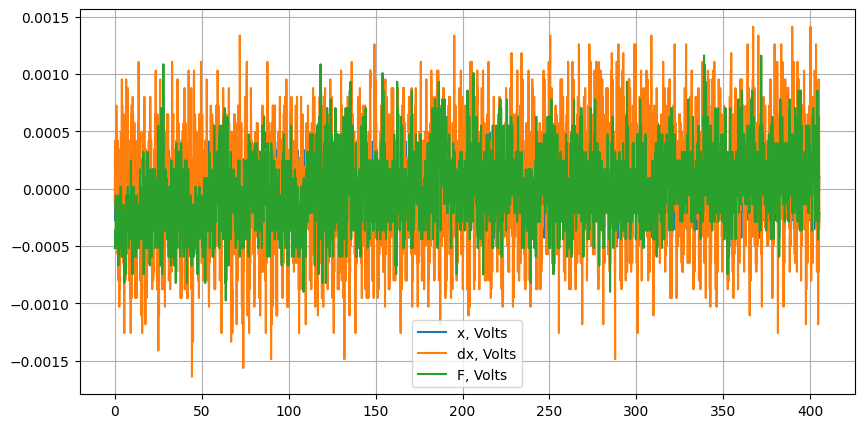

In [298]:
# convert to VOLTS using the calibration factor: [131.8, 4058.26, 150] for x, dx and F respectively
calibration = [131.8, 4058.26, 150]
df1['x'] = df1['x'] / calibration[0]
df1['dx'] = df1['dx'] / calibration[1]
df1['F'] = df1['F'] / calibration[2]

# plot the data
plt.figure(figsize=(10, 5))
plt.plot(df1['ts'], df1['x'], label='x, Volts')
plt.plot(df1['ts'], df1['dx'], label='dx, Volts')
plt.plot(df1['ts'], df1['F'], label='F, Volts')
plt.legend()
plt.grid()
plt.show()


In [299]:
# compute the median sample frequency of the data
dt = np.median(np.diff(df1['ts']))
fs = 1 / dt
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 10.101010101011168 Hz

nyquist: 5.050505050505584, n: 4045, f: [0.00000000e+00 2.49901289e-03 4.99802578e-03 ... 5.04550702e+00
 5.04800604e+00 5.05050505e+00]

len(dx_fft): 4045

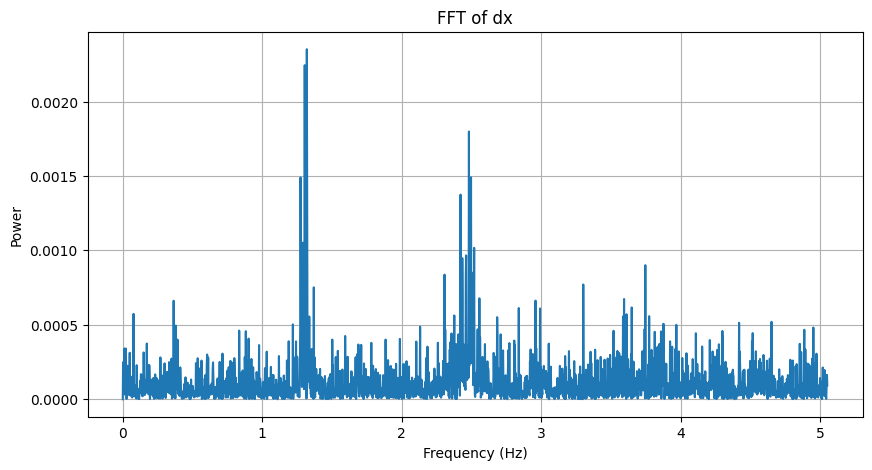

In [300]:
# plot the FFT of the data

y = df1["x"].values

srate = fs
timevec = df1["ts"].values

nyquist = srate / 2
n = len(y)
f = np.linspace(0, nyquist, n // 2)

print(f"nyquist: {nyquist}, n: {n}, f: {f}")

# compute the fft of dx
dx_fft = fft(y)

print(f"len(dx_fft): {len(dx_fft)}")

# plot the fft of dx
plt.figure(figsize=(10, 5))

dx_fft_power = np.abs(dx_fft[0 : n // 2]) ** 2

plt.plot(f, dx_fft_power)
# plt.plot(f, 2/n * np.abs(dx_fft[0:n//2]))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("FFT of dx")
plt.grid()
plt.show()

In [301]:
# find the frequency of the peaks, greather than 0.02 in the FFT of dx
peaks, _ = signal.find_peaks(dx_fft_power, height=0.02)
peaks_freq = f[peaks]
peaks_power = dx_fft_power[peaks]
print(f'peaks: {peaks}, peaks_freq: {peaks_freq}, peaks_power: {peaks_power}')


peaks: [], peaks_freq: [], peaks_power: []

order: 709.0, shape: [1, 1, 0, 0], frex: [0, 0.1, 0.12000000000000001, np.float64(5.050505050505584)]

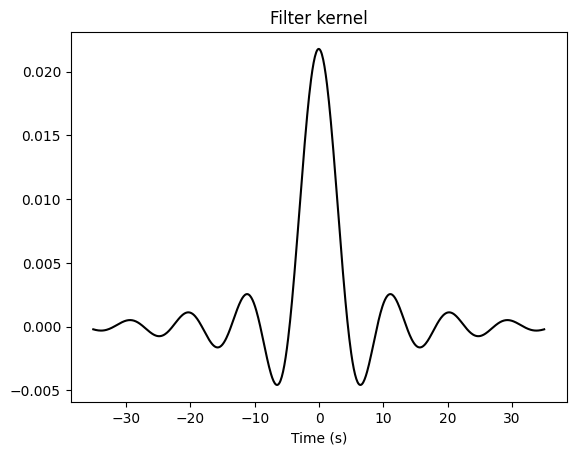

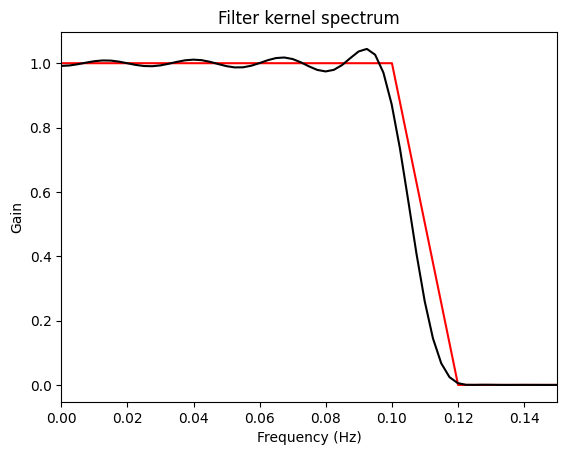

In [302]:
## now for lowpass filter
fcutoff = 0.1
transw = 0.2
order = np.floor(7 * fs / fcutoff) + 1
if order % 2 == 0:
    order += 1

shape = [1, 1, 0, 0]
frex = [0, fcutoff, fcutoff + fcutoff * transw, fs / 2]

print(f'order: {order}, shape: {shape}, frex: {frex}')

# filter kernel
filtkern = signal.firls(order, frex, shape, fs=fs)

# its power spectrum
filtkernX = np.abs(fft(filtkern, n)) ** 2

# power spectrum of signal
yX = np.abs(fft(y) / n) ** 2
hz = np.linspace(0, fs / 2, int(np.floor(n / 2) + 1))

plt.plot(np.arange(-order / 2, order / 2) / fs, filtkern, "k")
plt.xlabel("Time (s)")
plt.title("Filter kernel")
plt.show()

plt.plot(np.array(frex), shape, "r")  # desired amplitudes (ideal)
plt.plot(hz, filtkernX[: len(hz)], "k")  # actual filter kernel spectrum

plt.xlim([0, fcutoff * 1.5])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.title("Filter kernel spectrum")
plt.show()

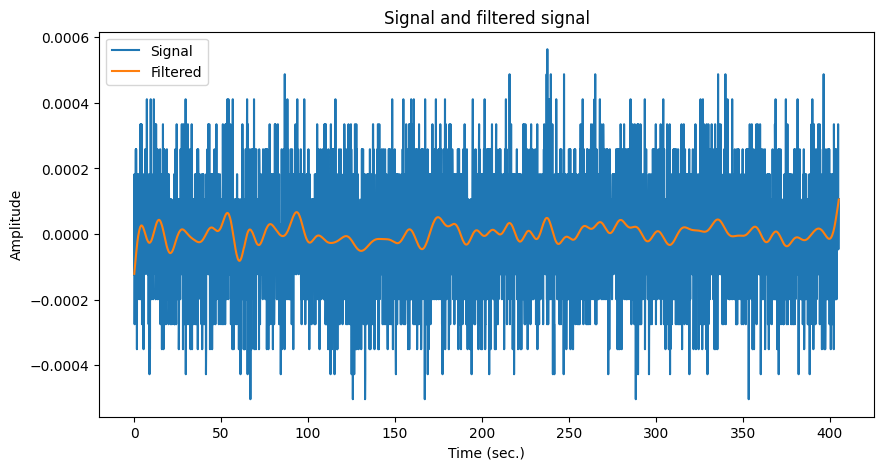

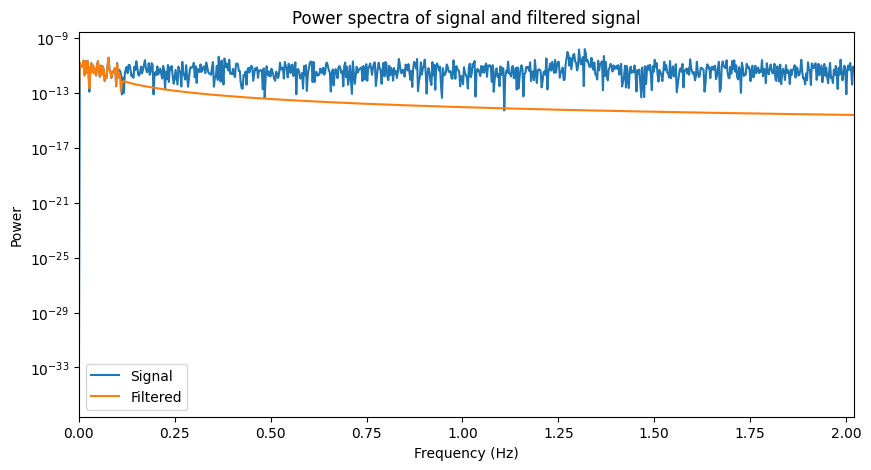

In [303]:
### now apply the filter to the data
yFilt = signal.filtfilt(filtkern, 1, y)

plt.figure(figsize=(10, 5))
plt.plot(timevec, y, label="Signal")
plt.plot(timevec, yFilt, label="Filtered")
plt.legend()
plt.xlabel("Time (sec.)")
plt.ylabel("Amplitude")
plt.title("Signal and filtered signal")
plt.show()

### power spectra of original and filtered signal
yOrigX = np.abs(fft(y) / n) ** 2
yFiltX = np.abs(fft(yFilt) / n) ** 2

plt.figure(figsize=(10, 5))
plt.plot(hz, yOrigX[: len(hz)], label="Signal")
plt.plot(hz, yFiltX[: len(hz)], label="Filtered")
plt.xlim([0, fs / 5])
plt.yscale("log")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power spectra of signal and filtered signal")
plt.show()